In [1]:
#Important Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from google.colab import drive
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Loaded dataset
drive.mount('/content/drive')
file = '/content/drive/MyDrive/sales_data_sample.csv'
df = pd.read_csv(file, encoding='latin1')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Dropping unnecessary columns
columns_to_drop = [
    'ADDRESSLINE1', 'ADDRESSLINE2', 'STATE', 'TERRITORY', 'CUSTOMERNAME', 'COUNTRY',
    'CITY', 'STATUS', 'QTR_ID', 'PHONE', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
    'POSTALCODE', 'PRODUCTLINE', 'PRODUCTCODE'
]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True, errors='ignore')

In [4]:
# Convert ORDERDATE to datetime
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')
df.dropna(subset=['ORDERDATE', 'SALES'], inplace=True)


In [5]:
# Feature engineering
df['YEAR'] = df['ORDERDATE'].dt.year
df['MONTH'] = df['ORDERDATE'].dt.month
df['HOLIDAY_SEASON'] = df['MONTH'].apply(lambda x: 1 if x in [11, 12] else 0)

In [6]:
# Monthly aggregation
monthly = df.groupby(['YEAR', 'MONTH'])['SALES'].sum().reset_index()
monthly['ds'] = pd.to_datetime(monthly[['YEAR', 'MONTH']].assign(DAY=1))
monthly.sort_values('ds', inplace=True)
monthly['HOLIDAY_SEASON'] = monthly['ds'].dt.month.apply(lambda x: 1 if x in [11, 12] else 0)

In [7]:
# Clip outliers (optional)
monthly['y'] = monthly['SALES'].clip(upper=monthly['SALES'].quantile(0.95))

# Log transform target
monthly['y'] = np.log1p(monthly['y'])  # log(1 + y) to handle zeros

In [8]:
# Train/test split
train = monthly.iloc[:-6]
test = monthly.iloc[-6:]

# Initialize improved Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

# Add external regressor
model.add_regressor('HOLIDAY_SEASON')

# Fit the model
model.fit(train[['ds', 'y', 'HOLIDAY_SEASON']])

# Forecast
future = model.make_future_dataframe(periods=6, freq='MS')
future['HOLIDAY_SEASON'] = future['ds'].dt.month.apply(lambda x: 1 if x in [11, 12] else 0)
forecast = model.predict(future)

# Reverse log transform
forecast['yhat'] = np.expm1(forecast['yhat'])
forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])
forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])

# Actual values for comparison
actual = monthly[['ds', 'SALES']].set_index('ds').loc[forecast['ds']]
forecast['actual'] = actual.values

# Evaluation
eval_df = forecast.dropna(subset=['actual'])
mae = mean_absolute_error(eval_df['actual'], eval_df['yhat'])
rmse = np.sqrt(mean_squared_error(eval_df['actual'], eval_df['yhat']))
mape = np.mean(np.abs((eval_df['actual'] - eval_df['yhat']) / eval_df['actual'])) * 100


INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz6gk52sp/py3gzyl0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz6gk52sp/55u4481g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46465', 'data', 'file=/tmp/tmpz6gk52sp/py3gzyl0.json', 'init=/tmp/tmpz6gk52sp/55u4481g.json', 'output', 'file=/tmp/tmpz6gk52sp/prophet_modelu6b2i5l1/prophet_model-20250703001441.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:14:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:14:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


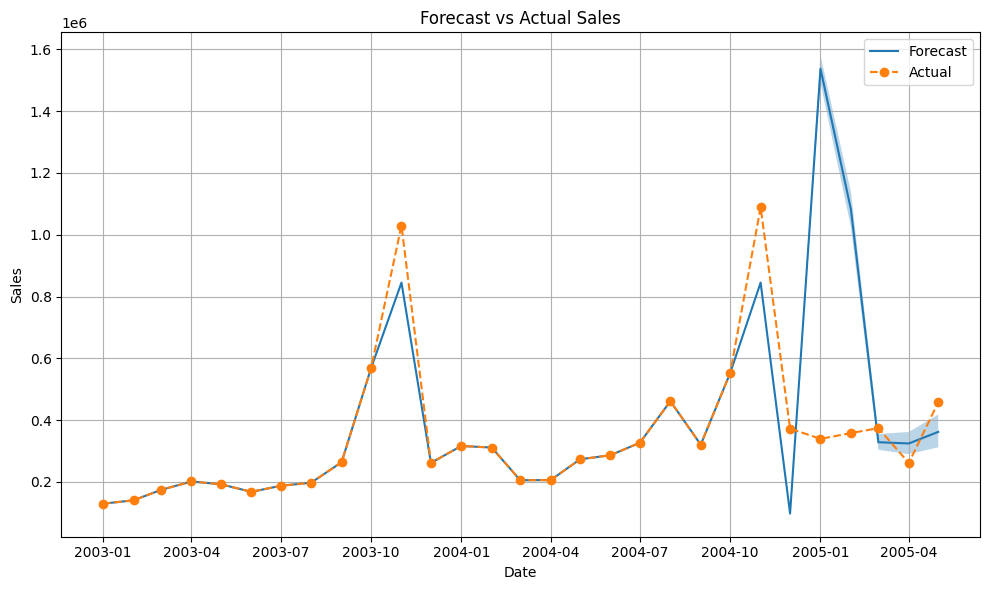

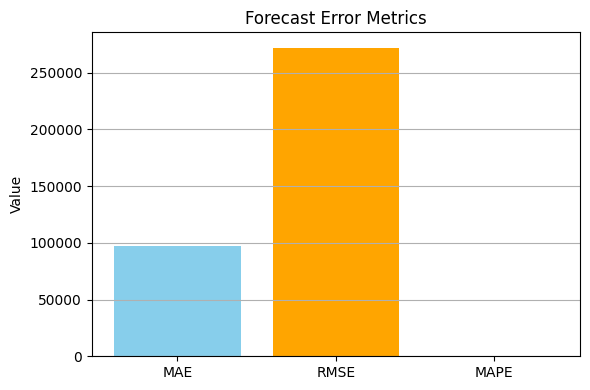

MAE  = 97,561.35
RMSE = 271,810.21
MAPE = 25.04%


In [9]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.plot(forecast['ds'], forecast['actual'], label='Actual', linestyle='dashed', marker='o')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
plt.title('Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Metrics plot
plt.figure(figsize=(6, 4))
plt.bar(['MAE', 'RMSE', 'MAPE'], [mae, rmse, mape], color=['skyblue', 'orange', 'lightgreen'])
plt.title('Forecast Error Metrics')
plt.ylabel('Value')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print metrics
print(f"MAE  = {mae:,.2f}")
print(f"RMSE = {rmse:,.2f}")
print(f"MAPE = {mape:.2f}%")


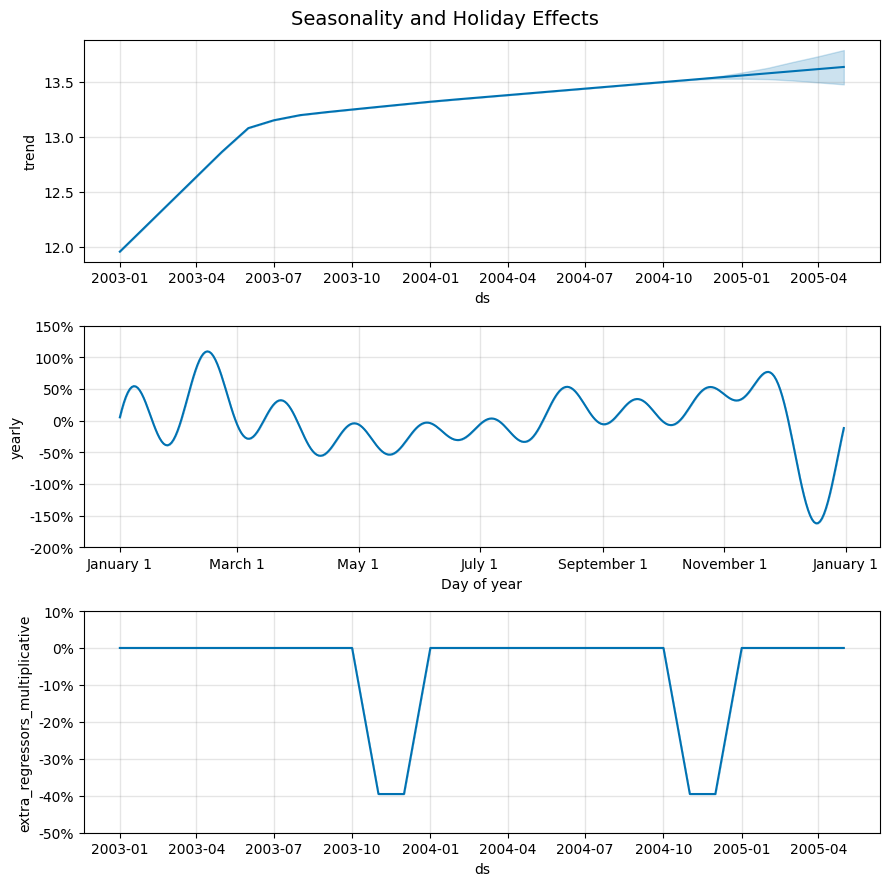

In [11]:
fig = model.plot_components(forecast)
plt.suptitle('Seasonality and Holiday Effects', fontsize=14)
plt.tight_layout()
plt.show()


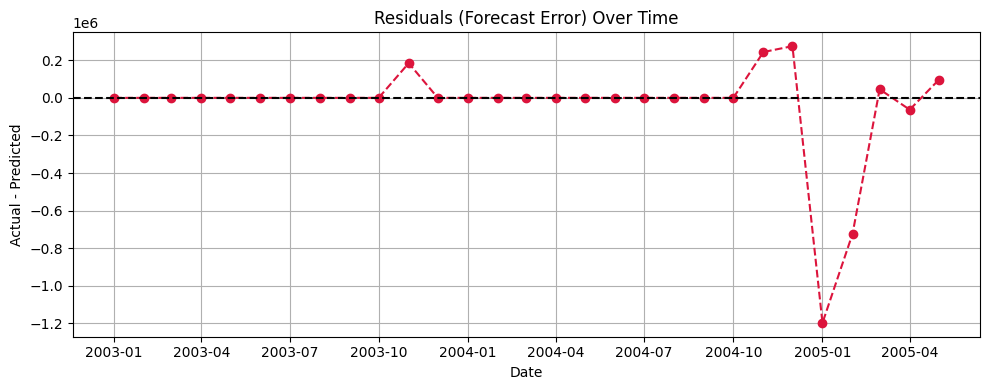

In [13]:
eval_df['residual'] = eval_df['actual'] - eval_df['yhat']
plt.figure(figsize=(10, 4))
plt.plot(eval_df['ds'], eval_df['residual'], marker='o', linestyle='dashed', color='crimson')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals (Forecast Error) Over Time')
plt.xlabel('Date')
plt.ylabel('Actual - Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
forecast_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'actual']]
forecast_output.to_csv('/content/drive/MyDrive/sales_forecast_results.csv', index=False)
